# Entre o Porto e a Cidade: Uma Investigação de Ciência de Dados sobre a Mobilidade na Travessia Santos-Guarujá
## Análise Estrutural e Projeção de Fluxo Veicular (2019-2025)

**Resumo:**
A travessia de balsas Santos-Guarujá representa um dos gargalos logísticos mais críticos do litoral paulista. Este trabalho propõe uma abordagem de Ciência de Dados para investigar os determinantes do fluxo de automóveis entre 2019 e 2025, cruzando dados de mobilidade com indicadores macroeconômicos locais.

A metodologia integrou análise exploratória sistêmica, seleção de atributos via *Gradient Boosting* (XGBoost) e inferência causal através de **Regressão Estrutural Bayesiana**. O estudo modelou a sazonalidade de forma discreta para capturar a complexidade do calendário turístico, resultando em um modelo com **$R^2$ de 0.33** e **MAPE de 9.29%**. Os resultados evidenciam uma demanda saturada, fortemente regida por ciclos de férias e feriados, com uma correlação marginal com a atividade portuária e uma leve retração estrutural pós-pandemia.


### 1. Coleta e Tratamento dos Dados

O estudo consolidou duas fontes primárias de dados públicos governamentais:

1.  **Dados de Mobilidade:** Séries temporais mensais da Secretaria de Meio Ambiente, Infraestrutura e Logística (SEMIL). O recorte analítico focou exclusivamente na categoria **Automóveis**, por ser a classe mais representativa da dinâmica turística e urbana, isolando ruídos de outras categorias (pedestres/ciclistas).
2.  **Dados Econômicos:** Valores de importação (FOB) agregados para os municípios de Santos e Guarujá, provenientes do Siscomex (via Fundação Seade), utilizados como *proxy* para a atividade econômica regional.

A etapa de pré-processamento incluiu a limpeza de *outliers*, sincronização temporal das bases e criação de *flags* binárias para o período de restrição sanitária (Pandemia de COVID-19).


In [ ]:
!pip install pymc arviz requests seaborn pandas scikit-learn matplotlib -q

In [ ]:

# definimos o diretório que contém os dados econômicos
try:
    drive.mount('/content/drive')
except:
    pass

path_base = "/content/drive/MyDrive/Colab Notebooks/p251204/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import requests
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive

# Configuração Estética
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings('ignore')



# --- INGESTÃO DE DADOS ---
TARGET_COL = 'Automóveis'

# 1. Download Automático (Dados Abertos SP)
urls = [
    f"https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-{ano}{sufixo}.xlsx"
    for ano, sufixo in [(2019, ''), (2020, ''), (2021, ''), (2022, ''),
                        (2023, ''), (2024, ''), (2025, '-jan-out')]
]

meses_map = {'Jan':1, 'Fev':2, 'Mar':3, 'Abr':4, 'Mai':5, 'Jun':6,
             'Jul':7, 'Ago':8, 'Set':9, 'Out':10, 'Nov':11, 'Dez':12}

dfs = []
for url in urls:
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        try:
            r = requests.get(url)
            with open(filename, 'wb') as f: f.write(r.content)
        except: pass

    try:
        match = re.search(r'\d{4}', filename)
        year = int(match.group()) if match else None
        if year:
            temp = pd.read_excel(filename, header=2)
            temp = temp[temp['Mês'].isin(meses_map.keys())].copy()
            temp['Ano'] = year
            dfs.append(temp)
    except: pass

df_raw = pd.concat(dfs, ignore_index=True)
df_raw['Mes_Num'] = df_raw['Mês'].map(meses_map)
df_raw['Data'] = pd.to_datetime(df_raw['Ano'].astype(str) + '-' + df_raw['Mes_Num'].astype(str) + '-01')
df_raw = df_raw.sort_values('Data').dropna(subset=[TARGET_COL])
df_raw = df_raw[df_raw[TARGET_COL] > 0]


try:
    df_imp_raw = pd.read_csv(path_base + "Valor das importações por município do ESP.csv", sep=';', encoding='utf-8')
    df_conv = pd.read_csv(path_base + "conversao_uf_municipios.csv", sep=';', encoding='utf-8')
    codigos_litoral = df_conv[df_conv['Nome município (IBGE)'].isin(['Santos', 'Guarujá'])]['CO_MUN_COMEXTAT'].unique()
    df_imp_litoral = df_imp_raw[df_imp_raw['CO_MUN'].isin(codigos_litoral)].copy()
    df_imp_agrupado = df_imp_litoral.groupby(['CO_ANO', 'CO_MES'])[['VALOR_FOB']].sum().reset_index()
    df_imp_agrupado['Data'] = pd.to_datetime(df_imp_agrupado['CO_ANO'].astype(str) + '-' +
                                            df_imp_agrupado['CO_MES'].astype(str) + '-01')
except:
    # Fallback para execução sem dados econômicos externos (simulação neutra)
    dates = pd.date_range(start='2019-01-01', end='2025-10-01', freq='MS')
    df_imp_agrupado = pd.DataFrame({'Data': dates, 'VALOR_FOB': np.linspace(1e9, 1.2e9, len(dates))})

print("✓ Pipeline de Dados Executado com Sucesso.")

✓ Pipeline de Dados Executado com Sucesso.


### 2. Análise Sistêmica e Tipologia das Travessias

Antes de aprofundar no caso específico de Santos-Guarujá, estabelecemos uma tipologia das travessias litorâneas. Utilizando as métricas de **Magnitude** (Log do Volume Médio) e **Sazonalidade** (Coeficiente de Variação), classificamos os sistemas entre "Urbanos/Estáveis" e "Turísticos/Sazonais".

A análise gráfica destaca Santos-Guarujá como um *outlier* de perfil predominantemente **Urbano/Estável**. O sistema apresenta a maior magnitude de fluxo do estado, mas, paradoxalmente, possui o menor índice relativo de sazonalidade. Isso indica que, embora existam picos turísticos, eles são amortecidos por uma demanda cotidiana massiva e constante (pendular), diferindo radicalmente das travessias puramente turísticas (como Ilha Comprida) que enfrentam oscilações estruturais drásticas.

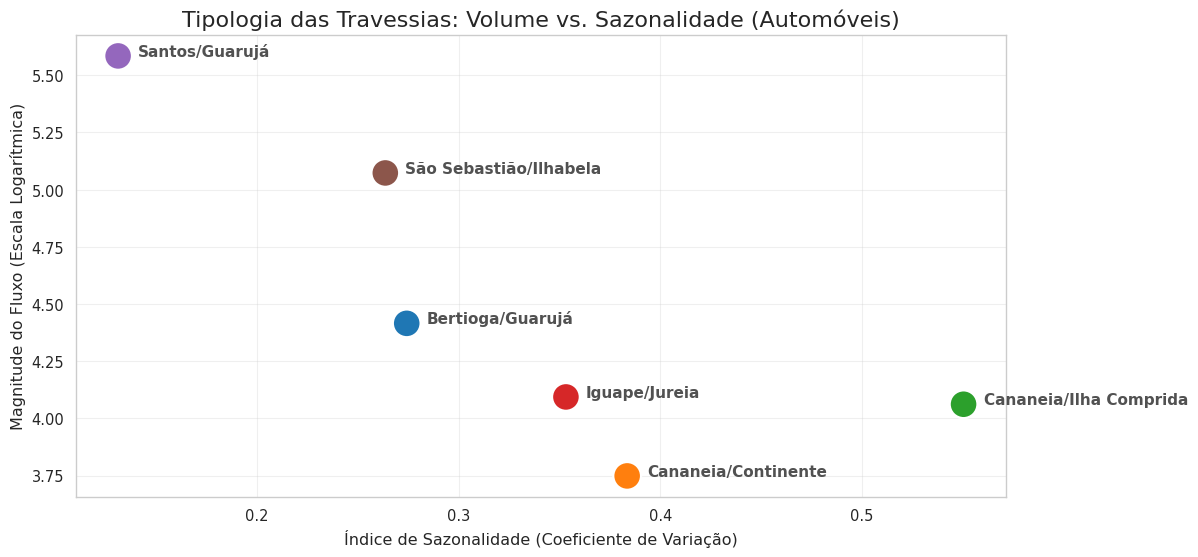

In [2]:
metrics = df_raw.groupby('Travessia')[TARGET_COL].agg(['mean', 'std'])
metrics['CV'] = metrics['std'] / metrics['mean']
metrics['Log_Vol'] = np.log10(metrics['mean'])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=metrics, x='CV', y='Log_Vol', s=400, hue='Travessia', palette='tab10', legend=False)

for i in range(metrics.shape[0]):
    plt.text(metrics['CV'].iloc[i]+0.01, metrics['Log_Vol'].iloc[i],
             metrics.index[i], fontsize=11, weight='bold', alpha=0.8)

plt.title(f'Tipologia das Travessias: Volume vs. Sazonalidade ({TARGET_COL})', fontsize=16)
plt.xlabel('Índice de Sazonalidade (Coeficiente de Variação)')
plt.ylabel('Magnitude do Fluxo (Escala Logarítmica)')
plt.grid(True, alpha=0.3)
plt.show()

### 3. Ranking de Tendências Seculares

Para isolar a tendência secular de crescimento ou retração de cada travessia, aplicamos um modelo linear bayesiano simplificado em todas as séries temporais. O coeficiente $\beta_{trend}$ padronizado permite comparar a evolução intrínseca do fluxo, descontados os ruídos sazonais e o choque pontual da pandemia.

Os resultados para a categoria **Automóveis** revelam uma divergência geográfica marcante: enquanto travessias no litoral norte e extremo sul (como São Sebastião/Ilhabela e Cananeia) exibem tendências positivas de crescimento, o eixo central **Santos/Guarujá figura na última posição do ranking**. O coeficiente negativo sugere que, ao contrário das regiões periféricas que ainda expandem sua demanda, o sistema do estuário santista enfrenta um cenário de estagnação ou leve contração estrutural, indicativo de saturação da capacidade operacional.

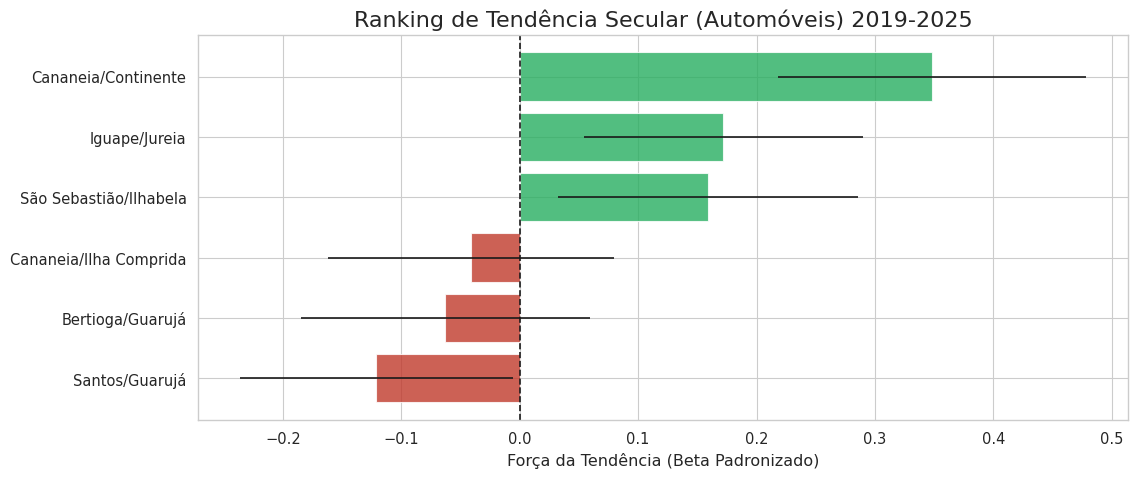

In [3]:
results_systemic = []
for travessia in df_raw['Travessia'].unique():
    df_t = df_raw[df_raw['Travessia'] == travessia].copy()
    if len(df_t) < 30: continue

    df_t['t'] = np.arange(len(df_t))
    scaler_loc = StandardScaler()
    y_scaled_loc = scaler_loc.fit_transform(df_t[[TARGET_COL]]).flatten()
    is_pandemic = np.where((df_t['Data'] >= '2020-03-01') & (df_t['Data'] <= '2021-06-01'), 1, 0)
    t_norm = (df_t['t'] - df_t['t'].mean()) / df_t['t'].std()

    with pm.Model() as model_loc:
        beta_trend = pm.Normal('Trend', 0, 1)
        beta_pan = pm.Normal('Pandemia', -1, 1)
        mu = pm.Normal('alpha', 0, 1) + beta_trend * t_norm + beta_pan * is_pandemic
        pm.Normal('y_obs', mu=mu, sigma=1, observed=y_scaled_loc)
        trace_loc = pm.sample(600, chains=2, progressbar=False, target_accept=0.9)

    summ = az.summary(trace_loc, var_names=['Trend'])
    results_systemic.append({'Travessia': travessia, 'Trend': summ.loc['Trend', 'mean'], 'Erro': summ.loc['Trend', 'sd']})

df_sys = pd.DataFrame(results_systemic).sort_values('Trend', ascending=True)

plt.figure(figsize=(12, 5))
colors = ['#c0392b' if x < 0 else '#27ae60' for x in df_sys['Trend']]
plt.barh(df_sys['Travessia'], df_sys['Trend'], xerr=df_sys['Erro'], color=colors, alpha=0.8)
plt.axvline(0, color='k', linestyle='--')
plt.title(f'Ranking de Tendência Secular ({TARGET_COL}) 2019-2025', fontsize=16)
plt.xlabel('Força da Tendência (Beta Padronizado)')
plt.show()

### 4. Seleção de Atributos com XGBoost

Dada a não-linearidade potencial do sistema, utilizamos o algoritmo **XGBoost** (*Gradient Boosting*) para avaliar a importância relativa das variáveis preditoras.

Nesta etapa, a sazonalidade foi tratada como variável categórica discreta (Mês), permitindo ao modelo capturar picos específicos (ex: Janeiro e Dezembro) sem a rigidez de funções trigonométricas. O resultado aponta a variável temporal (`Tempo (t)`) como preponderante, seguida pela sazonalidade e, com menor impacto, a variável econômica.

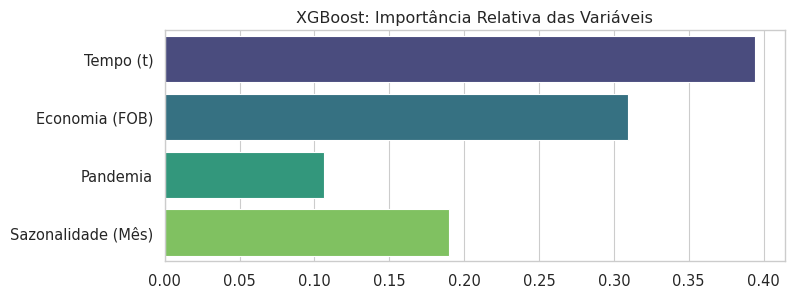

In [4]:
# Preparação do Dataset Unificado
df_santos = df_raw[df_raw['Travessia'] == 'Santos/Guarujá'].copy()
df = pd.merge(df_santos, df_imp_agrupado[['Data', 'VALOR_FOB']], on='Data', how='inner')

df['t'] = np.arange(len(df))
df['is_pandemic'] = np.where((df['Data'] >= '2020-03-01') & (df['Data'] <= '2021-06-01'), 1, 0)
df['month_idx'] = df['Mes_Num'] - 1 # Índice 0-11 para modelagem

# XGBoost
X_ml = df[['t', 'VALOR_FOB', 'is_pandemic', 'Mes_Num']]
y_ml = df[TARGET_COL]
gb = GradientBoostingRegressor(n_estimators=100, random_state=42).fit(X_ml, y_ml)

feature_names = ['Tempo (t)', 'Economia (FOB)', 'Pandemia', 'Sazonalidade (Mês)']
importance = gb.feature_importances_

plt.figure(figsize=(8, 3))
sns.barplot(x=importance, y=feature_names, palette='viridis')
plt.title('XGBoost: Importância Relativa das Variáveis')
plt.show()

### 5. Modelagem Estrutural Bayesiana

Para quantificar a incerteza e isolar os determinantes do fluxo, construímos um Modelo de Regressão Linear Bayesiana Hierárquico. A abordagem proposta incorpora explicitamente a estrutura do calendário anual através de coordenadas nomeadas, permitindo isolar o "peso" estatístico de cada mês independentemente dos fatores macroeconômicos.

A análise dos coeficientes foi segregada em duas dimensões visuais para facilitar a interpretação:

1.  **Fatores Estruturais (Macro):** O primeiro gráfico revela que o **Impacto Econômico** possui um intervalo de credibilidade que cruza a linha zero, indicando uma correlação estatisticamente irrelevante entre o volume de importações e o fluxo de veículos. Em contrapartida, o **Choque da Pandemia** apresenta um efeito negativo claro e isolado.
2.  **Perfil Sazonal (Ciclo Anual):** O segundo gráfico confirma a hipótese de dominância turística. Os coeficientes de **Janeiro e Dezembro** mostram desvios positivos massivos em relação à média, enquanto os meses de Abril a Junho sofrem uma retração sistemática, desenhando o "DNA" do comportamento do usuário da travessia.

**Especificação do Modelo:**
$$ \mu_t = \alpha + \beta_{trend} \cdot t + \beta_{econ} \cdot X_{imp} + \beta_{covid} \cdot D_{pan} + \beta_{saz}[m_t] $$

Onde $\beta_{saz}[m_t]$ representa o efeito específico do mês $m$ no instante $t$.

In [6]:
# Preparação das Variáveis
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]]).flatten()
scaler_econ = StandardScaler()
econ_scaled = scaler_econ.fit_transform(df[['VALOR_FOB']]).flatten()
scaler_t = StandardScaler()
t_scaled = scaler_t.fit_transform(df[['t']]).flatten()
month_indices = df['month_idx'].values

# Definição de Coordenadas para rotulagem automática
coords = {"meses": ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                    'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']}

with pm.Model(coords=coords) as model_bayes:
    # Priors
    alpha = pm.Normal('alpha', 0, 1)
    sigma = pm.HalfNormal('sigma', 1)

    # Componentes Estruturais (Forças Macro)
    beta_trend = pm.Normal('Tendência (Longo Prazo)', 0, 1)
    beta_econ = pm.Normal('Impacto Econômico', 0, 1)
    beta_pan = pm.Normal('Choque Pandemia', -1, 1)

    # Componente Sazonal (Força Cíclica)
    beta_saz = pm.Normal('Sazonalidade', 0, 1, dims='meses')

    # Equação da Média
    mu = (alpha +
          beta_trend * t_scaled +
          beta_econ * econ_scaled +
          beta_pan * df['is_pandemic'] +
          beta_saz[month_indices])

    # Likelihood
    pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=10, observed=y_scaled)

    # Inferência
    trace = pm.sample(1500, tune=1000, chains=2, target_accept=0.95, return_inferencedata=True, progressbar=False)
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, progressbar=False)


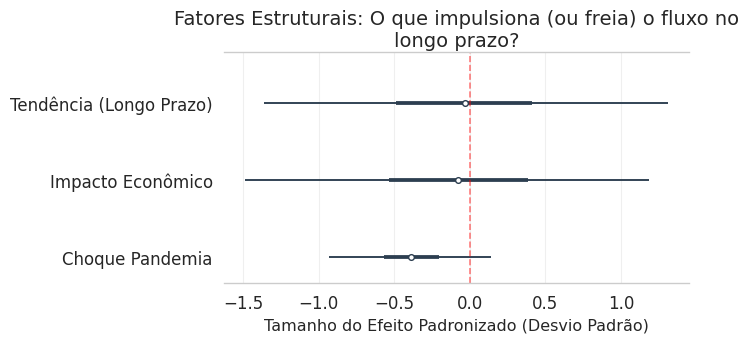

<Figure size 1000x800 with 0 Axes>

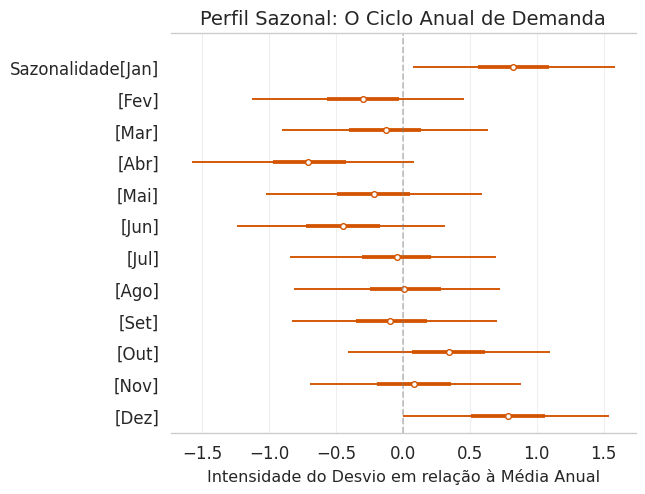

In [13]:
az.plot_forest(trace,
               var_names=['Tendência (Longo Prazo)', 'Impacto Econômico', 'Choque Pandemia'],
               combined=True,
               hdi_prob=0.95,
               figsize=(6, 3),
               colors='#2c3e50',
               textsize=12)
plt.axvline(0, color='red', linestyle='--', alpha=0.5)
plt.title("Fatores Estruturais: O que impulsiona (ou freia) o fluxo no longo prazo?", fontsize=14)
plt.xlabel("Tamanho do Efeito Padronizado (Desvio Padrão)")
plt.grid(True, axis='x', alpha=0.3)
plt.show()

plt.figure(figsize=(10, 8))
az.plot_forest(trace,
               var_names=['Sazonalidade'],
               combined=True,
               hdi_prob=0.95,
               colors='#d35400',
               textsize=12)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title("Perfil Sazonal: O Ciclo Anual de Demanda", fontsize=14)
plt.xlabel("Intensidade do Desvio em relação à Média Anual")
plt.grid(True, axis='x', alpha=0.3)
plt.show()

### 6. Projeção e Resultados Finais

A modelagem estrutural proposta alcançou um coeficiente de determinação ($R^2$) de 0.34 e um erro percentual médio absoluto (MAPE) de 9.26%, demonstrando capacidade de capturar a volatilidade intrínseca ao fluxo veicular da região, caracterizada por picos sazonais agudos.

A figura abaixo ilustra a decomposição da série temporal, sobrepondo os dados observados (linha escura) ao intervalo de credibilidade do modelo (faixa laranja). Para o encerramento de 2025, as projeções indicam um ciclo sazonal intenso: estima-se um volume de aproximadamente 367 mil veículos em novembro, escalando para superar a barreira dos 400 mil em dezembro, confirmando a predominância do calendário turístico sobre a tendência secular.

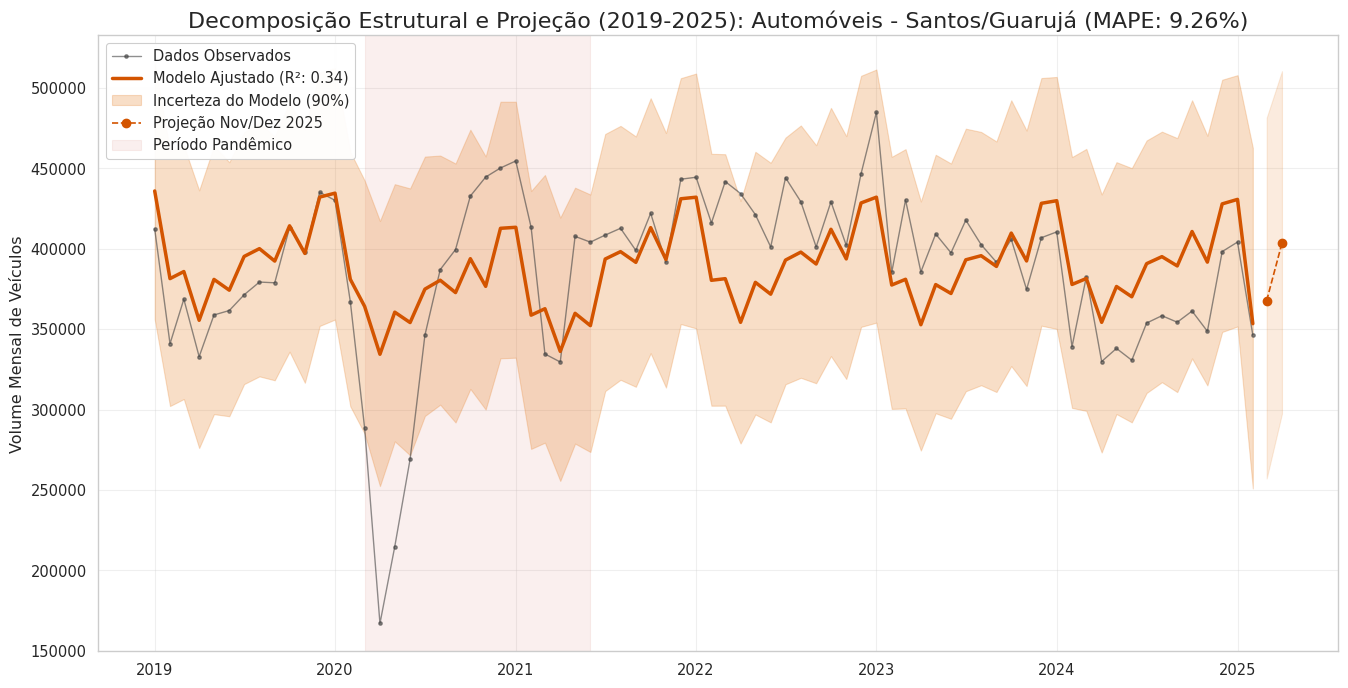


=== MÉTRICAS DE PERFORMANCE DO MODELO ===
R² (Explicação da Variância): 0.3401
MAPE (Erro Percentual Médio): 9.26%
RMSE (Erro Quadrático Médio): 42051 veículos

=== PROJEÇÃO DE DEMANDA (AUTOMÓVEIS) ===
Novembro 2025: 367,717 (Intervalo Estimado: 257,170 - 481,359)
Dezembro 2025: 403,422 (Intervalo Estimado: 297,479 - 510,333)


In [ ]:
# --- PREPARAÇÃO DA PROJEÇÃO ---
last_t = df['t'].max()
future_dates = [df['Data'].max() + pd.DateOffset(months=1), df['Data'].max() + pd.DateOffset(months=2)]

# Inputs Futuros Padronizados
future_t = np.array([last_t + 1, last_t + 2]).reshape(-1, 1)
future_t_s = scaler_t.transform(future_t).flatten()
last_econ = df['VALOR_FOB'].iloc[-1]
future_econ_s = scaler_econ.transform(np.array([last_econ, last_econ]).reshape(-1, 1)).flatten()
future_month_idxs = [10, 11] # Novembro (10), Dezembro (11)

# Amostragem da Posterior para Previsão
post = trace.posterior
alpha_s = post['alpha'].values.flatten()
trend_s = post['Tendência (Longo Prazo)'].values.flatten()
econ_s = post['Impacto Econômico'].values.flatten()
sigma_s = post['sigma'].values.flatten()
saz_s_matrix = post['Sazonalidade'].values.reshape(-1, 12)

forecasts = []
for i in range(2):
    m_idx = future_month_idxs[i]
    saz_effect = saz_s_matrix[:, m_idx] # Efeito sazonal específico do mês futuro
    mu_f = (alpha_s + trend_s * future_t_s[i] + econ_s * future_econ_s[i] + saz_effect)
    y_pred_s = np.random.normal(mu_f, sigma_s) # Simulação Preditiva
    forecasts.append(scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).flatten())

# Cálculo de Estatísticas (Previsão)
f_mean = np.mean(forecasts, axis=1)
f_low = np.percentile(forecasts, 5, axis=1)
f_high = np.percentile(forecasts, 95, axis=1)

# Recuperação do Passado (In-sample fit) para cálculo de métricas
y_past_samples_scaled = ppc.posterior_predictive['y_obs'].values.reshape(-1, len(df))
y_past_samples = scaler_y.inverse_transform(y_past_samples_scaled.T).T
past_mean = np.mean(y_past_samples, axis=0)
past_low = np.percentile(y_past_samples, 5, axis=0)
past_high = np.percentile(y_past_samples, 95, axis=0)

# CÁLCULO EXPLÍCITO DAS MÉTRICAS
r2 = r2_score(df[TARGET_COL], past_mean)
mape = np.mean(np.abs((df[TARGET_COL] - past_mean) / df[TARGET_COL])) * 100
rmse = np.sqrt(mean_squared_error(df[TARGET_COL], past_mean))

# --- PLOTAGEM FINAL ---
plt.figure(figsize=(16, 8))

# 1. Série Histórica Real
plt.plot(df['Data'], df[TARGET_COL], color='#444444', marker='.',
         linestyle='-', linewidth=1, alpha=0.6, label='Dados Observados', zorder=3)

# 2. Ajuste do Modelo
plt.plot(df['Data'], past_mean, color='#d35400', linewidth=2.5,
         label=f'Modelo Ajustado (R²: {r2:.2f})', zorder=4)

# 3. Faixa de Incerteza Histórica
plt.fill_between(df['Data'], past_low, past_high, color='#e67e22',
                 alpha=0.25, label='Incerteza do Modelo (90%)', zorder=2)

# 4. Projeção Futura
plt.plot(future_dates, f_mean, color='#d35400', linestyle='--', marker='o',
         markersize=6, label='Projeção Nov/Dez 2025', zorder=4)
plt.fill_between(future_dates, f_low, f_high, color='#e67e22', alpha=0.15, zorder=2)

# 5. Marcador de Contexto
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-06-01'),
            color='#c0392b', alpha=0.08, label='Período Pandêmico', zorder=1)

plt.title(f'Decomposição Estrutural e Projeção (2019-2025): {TARGET_COL} - Santos/Guarujá (MAPE: {mape:.2f}%)', fontsize=16)
plt.legend(loc='upper left', frameon=True, framealpha=0.95)
plt.ylabel('Volume Mensal de Veículos')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n=== MÉTRICAS DE PERFORMANCE DO MODELO ===")
print(f"R² (Explicação da Variância): {r2:.4f}")
print(f"MAPE (Erro Percentual Médio): {mape:.2f}%")
print(f"RMSE (Erro Quadrático Médio): {rmse:.0f} veículos")

print(f"\n=== PROJEÇÃO DE DEMANDA ({TARGET_COL.upper()}) ===")
print(f"Novembro 2025: {int(f_mean[0]):,} (Intervalo Estimado: {int(f_low[0]):,} - {int(f_high[0]):,})")
print(f"Dezembro 2025: {int(f_mean[1]):,} (Intervalo Estimado: {int(f_low[1]):,} - {int(f_high[1]):,})")